In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
trailing_stop_pred   = params.trailing_stop_pred_tick
look_back            = params.look_back_tick


In [3]:
df = pd.read_csv(params.final_csv, index_col=0, parse_dates=True)
df

,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth
2014-04-03 10:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.131792
2014-04-03 10:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132326
2014-04-03 10:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.132862
2014-04-03 10:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133399
2014-04-03 10:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,0.000000,28.65000,28.650000,0.000000,0.000000e+00,0,10,28.641405,28.658595,0.133939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.249034e+00,0.014819,173.91300,174.838390,-0.422065,3.294477e+08,1,20,173.512900,173.617100,0.001063
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.246621e+00,0.016242,173.73700,174.736890,-0.466939,3.288235e+08,1,20,173.328000,173.432000,0.005465
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.245701e+00,0.017430,173.53500,174.634390,-0.502359,3.283690e+08,1,20,173.258000,173.362000,0.007152
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.245284e+00,0.018221,173.38100,174.527890,-0.526778,3.272742e+08,1,20,173.228000,173.332000,0.007898


{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.35,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 10,
 'ETA_MIN': 2e-05,
 'INITIAL_LR': 0.0007,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 96,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


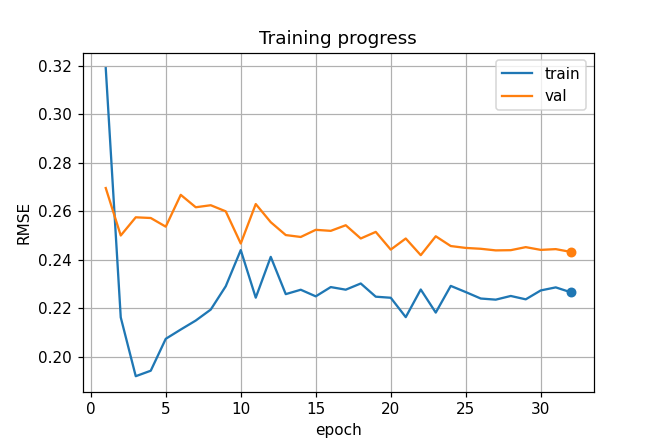

DualMemoryLSTM(
  (short_lstm): LSTM(13, 96, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.2399271376034191, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 128, batch_first=True)
  (do_long): Dropout(p=0.2549328387263775, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols_tick,
    label_col=params.label_col,
    regular_start=params.regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=params.regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1013805, val=211554, te=215642
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.46607
Test zero‐forecast baseline RMSE = 0.51381


std val: 0.30977806
std test: 0.32248157


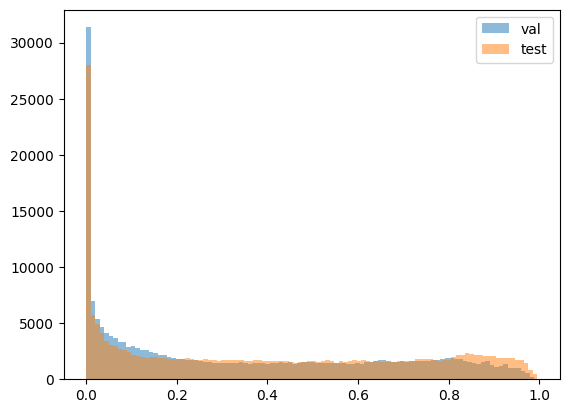

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
# train_rmse, train_preds = evaluate_model(
#     model_best, train_loader, device,
#     split_name="Train"
# )
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

# print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Validation:   0%|          | 0/414 [00:00<?, ?batch/s]


Validation RMSE over 211554 windows = 0.24320


Test:   0%|          | 0/422 [00:00<?, ?batch/s]


Test RMSE over 215642 windows = 0.26929
Val   preds: 211554
Test  preds: 215642


In [10]:
def add_pred_actions(
    df: pd.DataFrame,
    preds: np.ndarray,
    day_id_te: np.ndarray
) -> pd.DataFrame:
    """
    Returns a full-day DataFrame augmented with
      - pred_signal (NaN outside test-window)
      - pred_action (integer: -1/0/+1 everywhere)
    so downstream sim & plotting see the full x-axis.
    """
    # 1) Copy & init columns
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0  # default: no trade

    # 2) Identify test‐days by index normalize & map via day_id_te
    all_days = sorted(df_out.index.normalize().unique())
    test_ids = np.unique(day_id_te).astype(int)
    test_days = [all_days[i] for i in test_ids]

    # 3) Build mask of all post-start rows on test days
    mask = (
        df_out.index.normalize().isin(test_days)
        & (df_out.index.time >= params.regular_start_pred) 
    )
    idx = df_out.loc[mask].index

    # 4) Stamp your model’s predictions on those valid slots
    if len(idx) != len(preds):
        raise ValueError(
            f"Expected {len(idx)} prediction slots, got {len(preds)} preds"
        )
    df_out.loc[idx, "pred_signal"] = preds

    # 5) Generate & write back integer actions per test day
    for day in test_days:
        # slice just that day
        day_slice = df_out[df_out.index.normalize() == day]

        # generate_trade_actions expects pred_signal + writes pred_action
        day_actions = trades.generate_trade_actions(
            df                   = day_slice,
            col_signal           = "pred_signal",
            col_action           = "pred_action",
            buy_threshold        = pred_threshold,
            trailing_stop_thresh = trailing_stop_pred,
            regular_start        = params.regular_start
        )

        # overwrite int actions only on real trade timestamps
        df_out.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"]
            .fillna(0)
            .astype(int)
        )

    # 6) Save & split back out
    df_out.to_csv(params.pred_csv)

    return df_out.loc[idx]


In [11]:
df_test = add_pred_actions(
                        df=df, 
                        preds=test_preds, 
                        day_id_te=day_id_te
                        )

df_test

,open,high,low,close,atr_14,vwap_dev,bb_width_20,ma_5,ma_20,macd_12_26,obv,in_trading,hour,bid,ask,signal_smooth,pred_signal,pred_action
2023-10-12 12:30:00,141.270,141.2900,141.250,141.2900,0.050000,1.175319,0.002394,141.32200,141.444250,-0.057138,3.388274e+08,0,12,141.2476,141.3324,0.024647,0.196271,0
2023-10-12 12:31:00,141.270,141.2950,141.250,141.2750,0.048929,1.175088,0.002607,141.29900,141.434000,-0.061301,3.388273e+08,0,12,141.2326,141.3174,0.027168,0.196175,0
2023-10-12 12:32:00,141.270,141.3000,141.250,141.2600,0.049643,1.174857,0.002787,141.28700,141.422000,-0.065061,3.388270e+08,0,12,141.2176,141.3024,0.029698,0.196067,0
2023-10-12 12:33:00,141.300,141.3000,141.290,141.2900,0.048929,1.175319,0.002841,141.28300,141.411000,-0.064872,3.388272e+08,0,12,141.2476,141.3324,0.024985,0.195990,0
2023-10-12 12:34:00,141.300,141.3000,141.300,141.3000,0.046786,1.175473,0.002844,141.28300,141.400500,-0.063187,3.388273e+08,0,12,141.2576,141.3424,0.023465,0.195957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.249034,0.014819,173.91300,174.838390,-0.422065,3.294477e+08,1,20,173.5129,173.6171,0.001063,0.292150,0
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.246621,0.016242,173.73700,174.736890,-0.466939,3.288235e+08,1,20,173.3280,173.4320,0.005465,0.321249,0
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.245701,0.017430,173.53500,174.634390,-0.502359,3.283690e+08,1,20,173.2580,173.3620,0.007152,0.347360,1
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.245284,0.018221,173.38100,174.527890,-0.526778,3.272742e+08,1,20,173.2280,173.3320,0.007898,0.370484,0


In [12]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal_smooth','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal_smooth'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

,count,mean,std,min,25%,50%,75%,max,range,pearson_r_with_other
signal_smooth,215642.0,0.400002,0.322482,0.000000,0.075997,0.362453,0.697065,0.994637,0.994637,0.583922
pred_signal,215642.0,0.357470,0.141680,0.173835,0.254366,0.309433,0.429715,0.734927,0.561092,0.583922


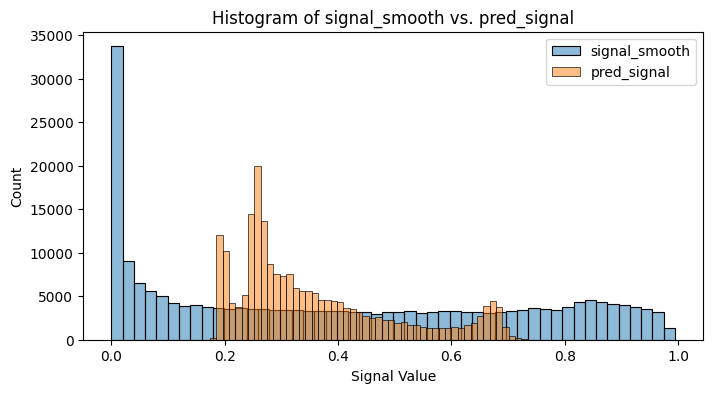

In [13]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal_smooth'], color='C0', alpha=0.5, bins=50, label='signal_smooth')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of signal_smooth vs. pred_signal')
plt.show()

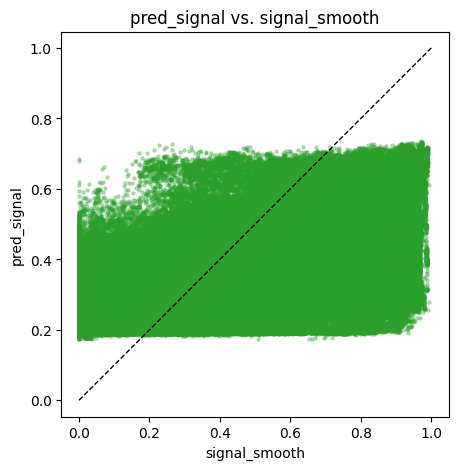

In [14]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal_smooth'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal_smooth')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal_smooth')
plt.axis('equal')
plt.show()

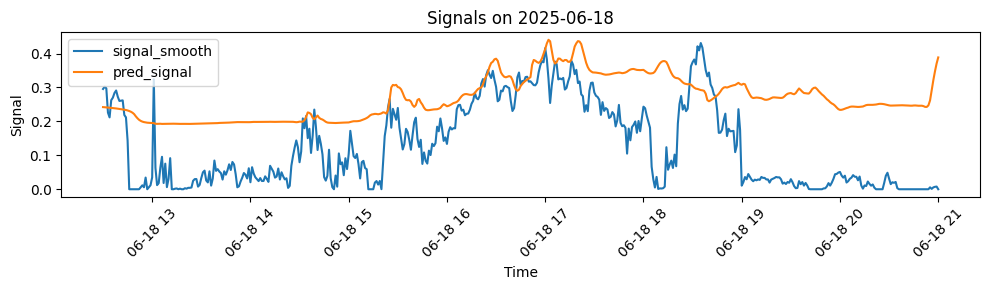

In [15]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal_smooth'], label='signal_smooth')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

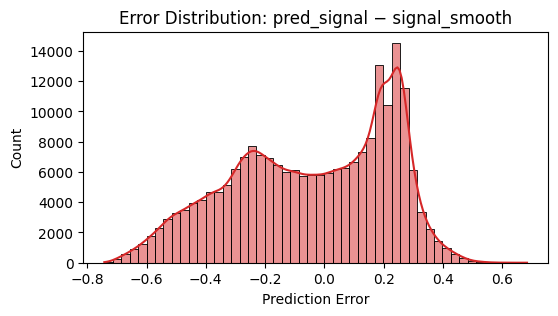

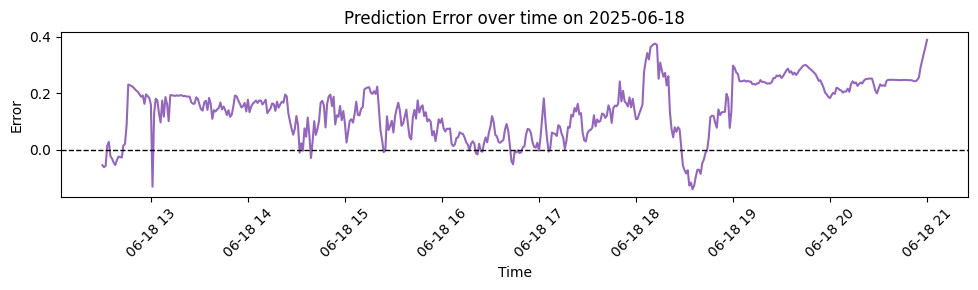

In [16]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal_smooth']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred_signal − signal_smooth')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_test,              # DF with pred_action
    col_action          = "pred_action",        # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2024-11:



=== Performance for 2024-11-01 00:00:00 ===
Buy & Hold Return ($): 1.918
Strategy Return ($): 4.007
Trades Returns ($): [2.298, 0.263, -0.007, 0.878, 0.578]



=== Performance for 2024-11-04 00:00:00 ===
Buy & Hold Return ($): -1.002
Strategy Return ($): 0.524
Trades Returns ($): [0.523]



=== Performance for 2024-11-05 00:00:00 ===
Buy & Hold Return ($): 0.053
Strategy Return ($): 0.426
Trades Returns ($): [0.283, 0.143]



=== Performance for 2024-11-06 00:00:00 ===
Buy & Hold Return ($): 1.645
Strategy Return ($): 1.525
Trades Returns ($): [1.525]



=== Performance for 2024-11-07 00:00:00 ===
Buy & Hold Return ($): 3.158
Strategy Return ($): 2.638
Trades Returns ($): [2.638]



=== Performance for 2024-11-08 00:00:00 ===
Buy & Hold Return ($): -2.228
Strategy Return ($): 0.193
Trades Returns ($): [0.118, -0.208, 0.282]



=== Performance for 2024-11-11 00:00:00 ===
Buy & Hold Return ($): 0.612
Strategy Return ($): 0.712
Trades Returns ($): [0.712]



=== Performance for 2024-11-12 00:00:00 ===
Buy & Hold Return ($): 1.481
Strategy Return ($): 1.25
Trades Returns ($): [1.131, -1.333, 1.451]



=== Performance for 2024-11-13 00:00:00 ===
Buy & Hold Return ($): -1.278
Strategy Return ($): 0.984
Trades Returns ($): [0.372, 0.022, 0.373, 0.217]



=== Performance for 2024-11-14 00:00:00 ===
Buy & Hold Return ($): -2.756
Strategy Return ($): 0.311
Trades Returns ($): [0.311]



=== Performance for 2024-11-15 00:00:00 ===
Buy & Hold Return ($): -1.024
Strategy Return ($): 0.787
Trades Returns ($): [0.204, 0.184, 0.399]



=== Performance for 2024-11-18 00:00:00 ===
Buy & Hold Return ($): 2.115
Strategy Return ($): 1.411
Trades Returns ($): [0.386, 1.025]



=== Performance for 2024-11-19 00:00:00 ===
Buy & Hold Return ($): 3.544
Strategy Return ($): 3.474
Trades Returns ($): [3.475]



=== Performance for 2024-11-20 00:00:00 ===
Buy & Hold Return ($): -1.606
Strategy Return ($): 0.081
Trades Returns ($): [0.655, 0.155, -0.73]



=== Performance for 2024-11-21 00:00:00 ===
Buy & Hold Return ($): -4.741
Strategy Return ($): 2.962
Trades Returns ($): [1.232, 1.73]



=== Performance for 2024-11-22 00:00:00 ===
Buy & Hold Return ($): -0.259
Strategy Return ($): 0.817
Trades Returns ($): [0.191, 0.627]



=== Performance for 2024-11-25 00:00:00 ===
Buy & Hold Return ($): 1.54
Strategy Return ($): 0.484
Trades Returns ($): [1.36, -0.52, 0.037, -0.393]



=== Performance for 2024-11-26 00:00:00 ===
Buy & Hold Return ($): 0.854
Strategy Return ($): 1.569
Trades Returns ($): [1.568]



=== Performance for 2024-11-27 00:00:00 ===
Buy & Hold Return ($): 0.829
Strategy Return ($): 0.75
Trades Returns ($): [0.548, 0.169, 0.039, 0.184, -0.137, -0.041, 0.169, 0.292, -0.232, -0.242]



=== Performance for 2024-11-29 00:00:00 ===
Buy & Hold Return ($): 0.908
Strategy Return ($): 0.39
Trades Returns ($): [0.704, -0.171, -0.122, -0.022]

Overall Summary (2024-11-01 = 169.4508 → 2024-11-29 = 168.8984)

One-time buy&hold gain: -0.552
Buy & Hold – each day ($): 3.763
Strategy Return ($): 25.295
Trades Count: 54
Strategy return per trade: 0.468
Num. trading days: 20
Strategy return per trading day: 1.265


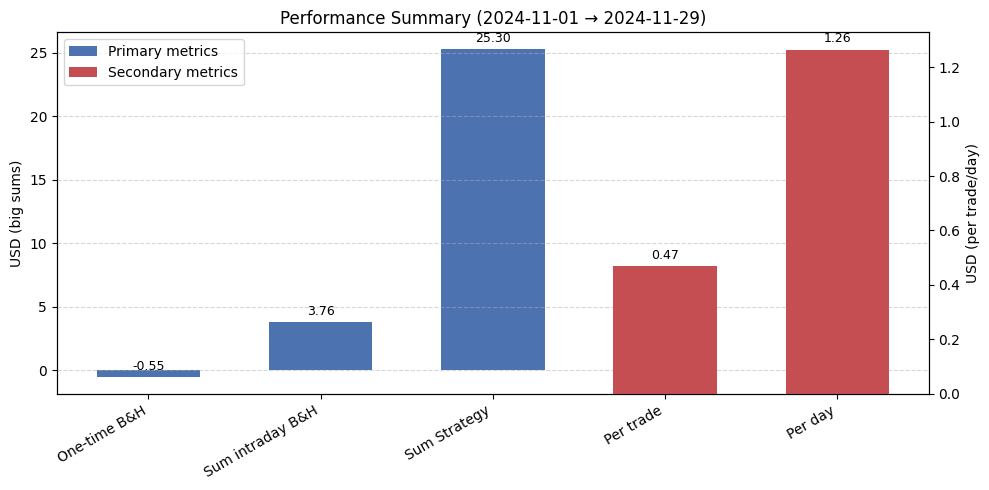


Overall Summary (2023-10-12 = 140.4855 → 2025-06-18 = 173.5576)

One-time buy&hold gain: 33.072
Buy & Hold – each day ($): -78.420
Strategy Return ($): 407.340
Trades Count: 1024
Strategy return per trade: 0.398
Num. trading days: 422
Strategy return per trading day: 0.965


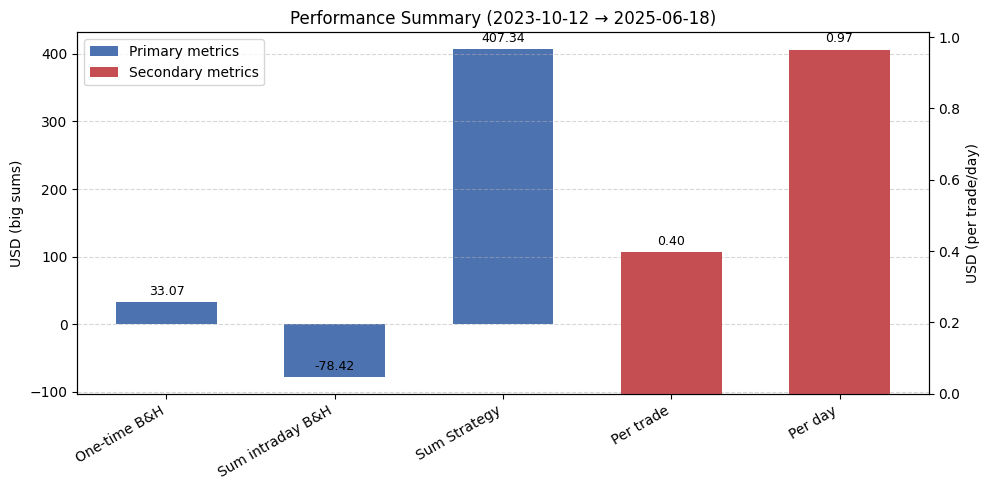

In [18]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = pred_threshold,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
plots.aggregate_performance(performance_month, df_month)

# 4) Overall summary across ALL days, with date range
plots.aggregate_performance(performance_all, df_test)